# tiler object tutorial

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=4, cores=4, 
#                     walltime='04:00:00')
#cluster = PBSCluster()
#w = cluster.scale(jobs=1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:47915 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


---

# load data

In [3]:
ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])

## downsample
#ds = ds.isel(time=slice(0,24))
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [4]:
# create tiler
tl = pa.tiler(ds=ds)

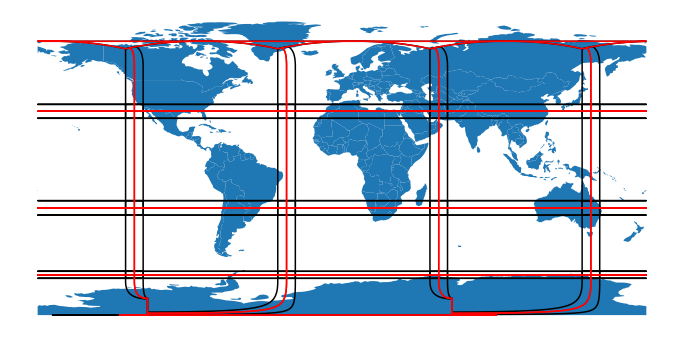

In [5]:
crs = tl.crs_wgs84

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
for b in tl.G['boundaries']:
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
ax.set_axis_off()
plt.show()

In [6]:
# generate synthetic points and assign them to tiles
points = pa.generate_randomly_located_data()
points

0      POINT (169.66363 45.69966)
1      POINT (174.52924 54.91948)
2      POINT (171.77420 56.85936)
3       POINT (18.32009 21.42332)
4       POINT (62.43433 62.83885)
                  ...            
995    POINT (156.33094 73.70942)
996     POINT (67.12885 18.87679)
997      POINT (48.26620 6.06848)
998      POINT (51.74952 7.07701)
999     POINT (51.48573 38.57085)
Length: 1000, dtype: geometry

In [7]:
# assign points to tiles
tiles = tl.assign(gs=points)

<AxesSubplot:>

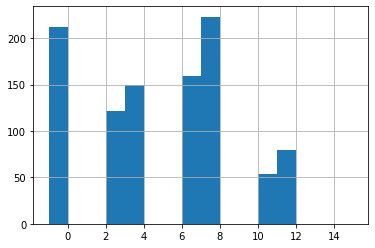

In [8]:
tiles.hist(bins=np.arange(-1,tl.N_tiles))

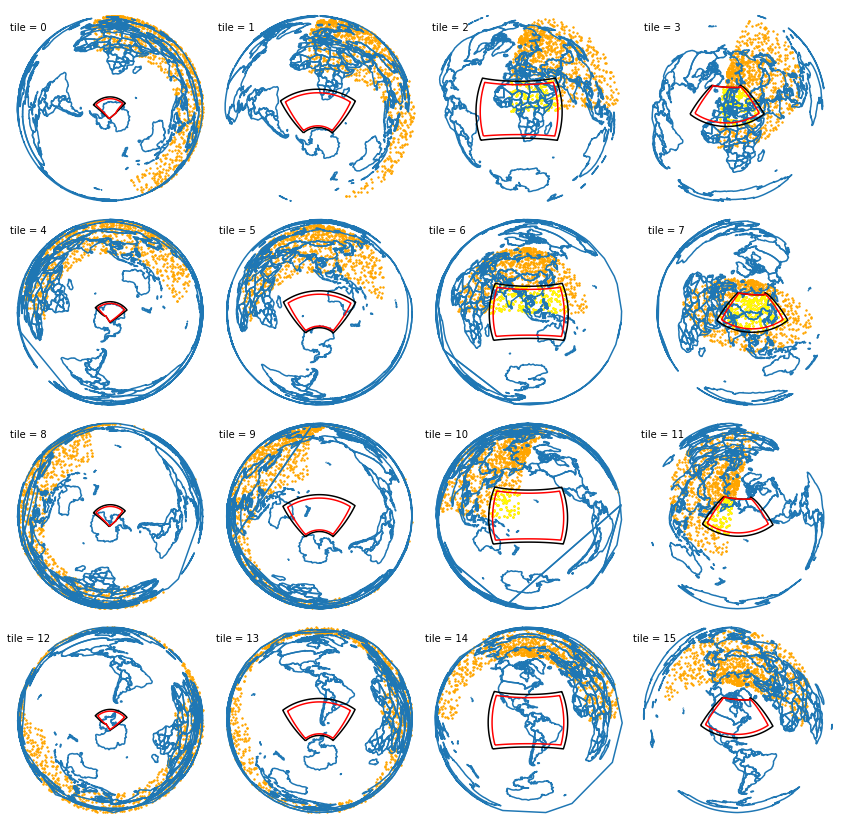

In [9]:

fig = plt.figure(figsize=(15, 15), constrained_layout=False)
grid = fig.add_gridspec(int(tl.N_tiles/4), 4, wspace=0.0, hspace=0.0)

ms = 2

i=0
for t, b, crs in zip(tl.G['tiles'], tl.G['boundaries'], tl.CRS):
    ax = fig.add_subplot(grid[int(i/4), i % 4]) 
    
    new_world = world.to_crs(crs)
    new_world.boundary.plot(ax=ax)
    
    t.boundary.plot(ax=ax, color="black")
    b.boundary.plot(ax=ax, color="red")

    new_points = points.to_crs(crs)
    new_points_in_tile = new_points[new_points.within(t.geometry[0])]

    new_points.plot(ax=ax, markersize=ms, color='orange')
    if new_points_in_tile.size>0:
        new_points_in_tile.plot(ax=ax, markersize=ms, color='yellow')

    ax.text(0.1, 0.9, 'tile = {}'.format(i),
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes)
    ax.set_axis_off()
    
    i+=1

plt.show()    

---

## store tiler and reload

In [10]:
tile_dir = '/home1/datahome/aponte/mit_equinox/parcels/test'
tl.store(tile_dir)

Tiler stored in /home1/datahome/aponte/mit_equinox/parcels/test


In [11]:
new_tl = pa.tiler(tile_dir=tile_dir)

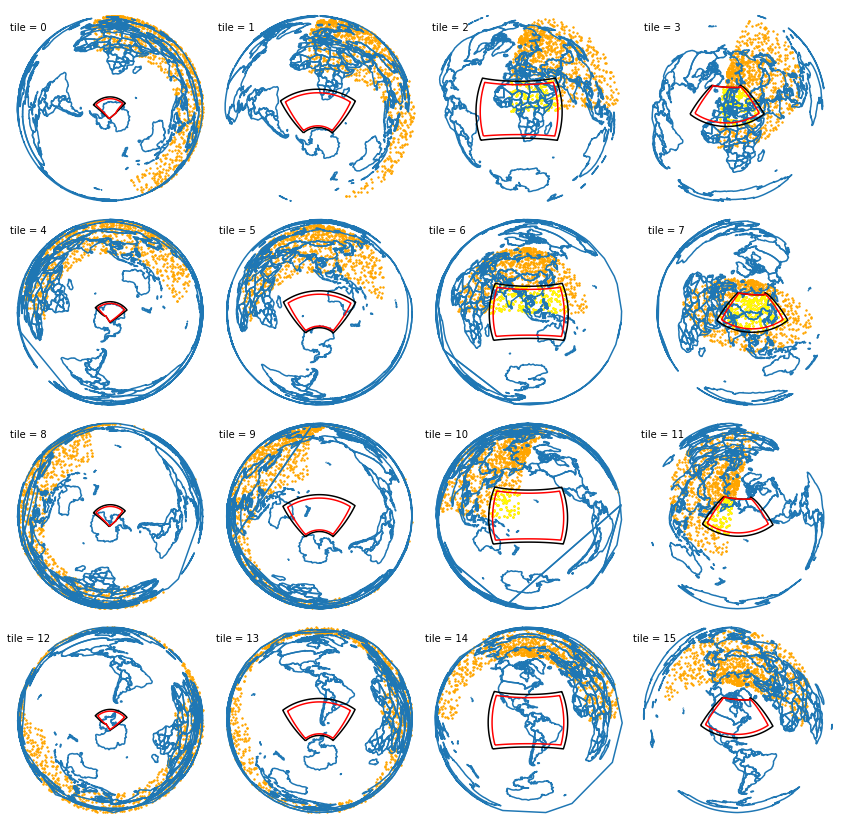

In [12]:

fig = plt.figure(figsize=(15, 15), constrained_layout=False)
grid = fig.add_gridspec(int(tl.N_tiles/4), 4, wspace=0.0, hspace=0.0)

ms = 2

i=0
for t, b, crs in zip(new_tl.G['tiles'], new_tl.G['boundaries'], tl.CRS):
    ax = fig.add_subplot(grid[int(i/4), i % 4]) 
    
    new_world = world.to_crs(crs)
    new_world.boundary.plot(ax=ax)
    
    t.boundary.plot(ax=ax, color="black")
    b.boundary.plot(ax=ax, color="red")

    new_points = points.to_crs(crs)
    new_points_in_tile = new_points[new_points.within(t.geometry[0])]

    new_points.plot(ax=ax, markersize=ms, color='orange')
    if new_points_in_tile.size>0:
        new_points_in_tile.plot(ax=ax, markersize=ms, color='yellow')

    ax.text(0.1, 0.9, 'tile = {}'.format(i),
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes)
    ax.set_axis_off()
    
    i+=1

plt.show()    

---
## tile dataset with tiler

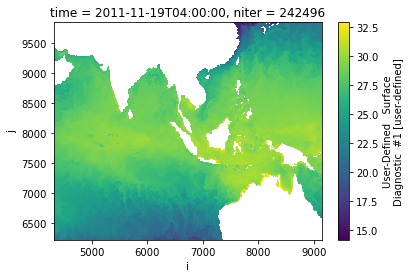

In [13]:
ds_tiled = tl.tile(ds, tile=6)
ds_tiled.SST.isel(time=100, i=slice(0,None,4), j=slice(0,None,4)).plot()

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


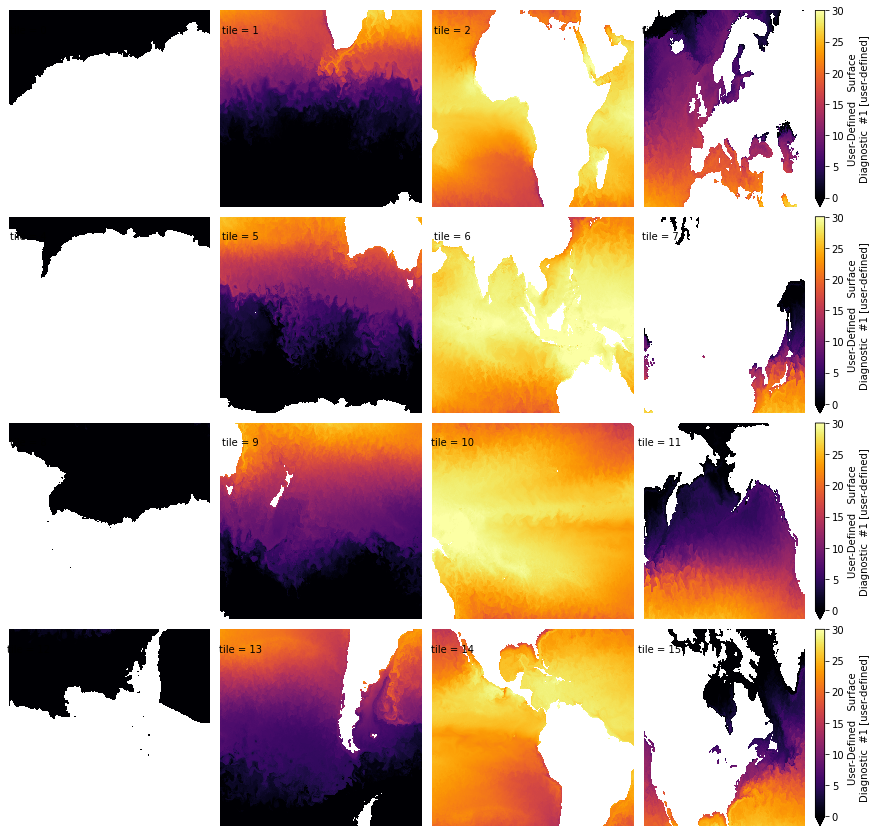

In [17]:
ds_tiled = tl.tile(ds)

fig = plt.figure(figsize=(15, 15), constrained_layout=False)
grid = fig.add_gridspec(int(tl.N_tiles/4), 4, wspace=0.05, hspace=0.05)

i=0
for d in ds_tiled:
    ax = fig.add_subplot(grid[int(i/4), i % 4])
    add_cbar = (i%4==3)
    (d.SST
     .isel(time=100, i=slice(0,None,4), j=slice(0,None,4))
     .plot(ax=ax, vmin=0., vmax=30., cmap='inferno', add_colorbar=add_cbar)
    )

    ax.text(0.1, 0.9, 'tile = {}'.format(i),
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes)
    ax.set_axis_off()
    ax.set_title('')
    i+=1

plt.show()        

---

In [13]:
cluster.close()